To install rascal:
(NOTE: See the top-level README for the most up-to-date installation instructions.)
+ mkdir ../build 
+ cd build
+ cmake -DCMAKE_BUILD_TYPE=Release -DBUILD_TESTS=ON ..
+ make -j 4
+ make install

In [1]:
# !export OMP_NUM_THREADS=1
# !export NUMBA_THREADING_LAYER=1
# from mkl import set_num_threads
# set_num_threads(1)

In [1]:
%matplotlib inline
from matplotlib import pylab as plt

import os, sys
from ase.io import read
sys.path.insert(0,"../build/")

import sys
import time
import rascal
import json

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
import sys

import json

from rascal.representations import SphericalInvariants as SOAP
from rascal.models import Kernel, PseudoPoints
from rascal.neighbourlist import AtomsList

In [2]:
from scipy.sparse.linalg import  svds

def do_CUR(X, Nsel, act_on='sample', is_deterministic=False,seed=10,verbose=True):
    """ Apply CUR selection of Nsel rows or columns of the
    given covariance matrix. """
    U,S,VT = svds(X, Nsel)
    if 'sample' in act_on:
        weights = np.mean(np.square(U),axis=1)
    elif 'feature' in act_on:
        weights = np.mean(np.square(VT),axis=0)
    if is_deterministic is True:
        # sorting is smallest to largest hence the minus
        sel = np.argsort(-weights)[:Nsel]
    elif is_deterministic is False:
        np.random.seed(seed)
        # sorting is smallest to largest hence the minus
        sel = np.argsort(np.random.rand(*weights.shape) - weights)[:Nsel]

    if verbose is True:
        if 'sample' in act_on:
            C = X[sel,:]
        elif 'feature' in act_on:
            C = X[:,sel]
        Cp = np.linalg.pinv(C)
        err = np.sqrt(np.sum((X - np.dot(np.dot(X,Cp),C))**2))
        print('Reconstruction RMSE={:.3e}'.format(err))
    
    return sel

In [3]:
def extract_ref(frames,info_key='dft_formation_energy_per_atom_in_eV',array_key='zeros'):
    y,f = [], []
    for frame in frames:
        y.append(frame.info[info_key])
        if array_key is None:
            pass
        elif array_key == 'zeros':
            f.append(np.zeros(frame.get_positions().shape))
        else:
            f.append(frame.get_array(array_key))
    y= np.array(y)
    try:
        f = np.concatenate(f)
    except:
        pass
    return y,f

In [4]:
class CURFilter(object):
    def __init__(self, representation, Nselect, act_on='sample per specie', is_deterministic=True, seed=10):
        self._representation = representation
        self.Nselect = Nselect
        if act_on in ['sample','sample per specie','feature']:
            self.act_on = act_on
        else:
            raise 'Wrong input: {}'.format(act_on)
        self.is_deterministic = is_deterministic
        self.seed = seed
        self.selected_ids = None

    def fit_transform(self, managers):
        if self.act_on in ['sample per specie']:
            # get the dense feature matrix
            X = managers.get_features(self._representation)
            # get various info from the structures about the center atom species and indexing
            sps = list(self.Nselect.keys())
            types = []
            strides_by_sp = {sp:[0] for sp in sps}
            global_counter = {sp: 0 for sp in sps}
            map_by_manager = [{} for ii in range(len(managers))]
            for i_man, man in enumerate(managers):
                counter = {sp: 0 for sp in sps}
                for i_at, at in enumerate(man):
                    types.append(at.atom_type)
                    if at.atom_type in sps:
                        map_by_manager[i_man][global_counter[at.atom_type]] = i_at
                        counter[at.atom_type] += 1
                        global_counter[at.atom_type] += 1
                    else:
                        raise ValueError('Atom type {} has not been specified in fselect: {}'.format(
                                    at.atom_type, self.Nselect))
                for sp in sps:
                    strides_by_sp[sp].append(counter[sp])
                    
            for sp in sps:
                strides_by_sp[sp] = np.cumsum(strides_by_sp[sp])
            indices_by_sp = {sp:[] for sp in sps}
            for ii,sp in enumerate(types):        
                indices_by_sp[sp].append(ii)
                
            print('The number of pseudo points selected by central atom species is: {}'.format(self.Nselect))
            
            
            X_by_sp = {}
            for sp in sps:
                X_by_sp[sp] = X[indices_by_sp[sp]]
            self.XX = X_by_sp
            # split the dense feature matrix by center species and apply CUR decomposition    
            selected_ids_by_sp = {}
            for sp in sps:
                print('Selecting species: {}'.format(sp))
                selected_ids_by_sp[sp] = np.sort(do_CUR(X_by_sp[sp],self.Nselect[sp], self.act_on,
                                               self.is_deterministic, self.seed))
            
        
            # convert selected center indexing into the rascal format
            self.selected_ids = [[] for ii in range(len(managers))]
            i_manager = {sp:0 for sp in sps}
            for sp in sps:
                for idx in selected_ids_by_sp[sp]:
                    carry_on = True
                    while carry_on:
                        if idx >= strides_by_sp[sp][i_manager[sp]] and idx < strides_by_sp[sp][i_manager[sp]+1]:
                            self.selected_ids[i_manager[sp]].append(map_by_manager[i_manager[sp]][idx])
                            carry_on = False
                        else:
                            i_manager[sp] += 1                       
            for ii in range(len(self.selected_ids)):
                self.selected_ids[ii] = list(np.sort(self.selected_ids[ii]))
            pseudo_points = PseudoPoints(self._representation)
            pseudo_points.extend(managers, self.selected_ids)
        return pseudo_points


In [5]:
from scipy.stats import spearmanr

def get_r2(y_pred,y_true):
    weight = 1
    sample_weight = None
    numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,dtype=np.float64)
    denominator = (weight * (y_true - np.average(
        y_true, axis=0, weights=sample_weight)) ** 2).sum(axis=0,dtype=np.float64)
    output_scores = 1 - (numerator / denominator)
    return np.mean(output_scores)

def get_mae(ypred,y):
    return np.mean(np.abs(ypred-y))
def get_rmse(ypred,y):
    return np.sqrt(np.mean((ypred-y)**2))
def get_sup(ypred,y):
    return np.amax(np.abs((ypred-y)))
def get_spearman(ypred,y):
    corr,_ = spearmanr(ypred,y)
    return corr

score_func = dict(
    MAE=get_mae,
    RMSE=get_rmse,
    SUP=get_sup,
    R2=get_r2,
    CORR=get_spearman
)

def get_score(ypred,y):
    scores = {}
    for k,func in score_func.items():
        scores[k] = func(ypred,y)
    return scores
def print_score(ypred,y):
    scores = get_score(ypred,y)
    print(' '.join(map(lambda x:'{}={:.2e}'.format(*x), scores.items())))

class KRR(object):
    def __init__(self, weights, kernel, X_train, self_contributions):
        # Weights of the krr model
        self.weights = weights
        self.kernel = kernel
        self.X_train = X_train
        self.self_contributions = self_contributions
        self.target_type = kernel.target_type
    
    def _get_property_baseline(self, managers):
        if self.target_type == 'Structure':
            Y0 = np.zeros(len(managers))
            for i_manager, manager in enumerate(managers):
                for center in manager:
                    Y0[i_manager] += self.self_contributions[center.atom_type]
        elif self.target_type == 'Atom':
            n_centers = 0
            for manager in managers:
                n_centers += len(manager)
            Y0 = np.zeros(n_centers)
            i_center = 0
            for manager in managers:
                for center in manager:
                    Y0[i_center] = self.self_contributions[center.atom_type]
                    i_center += 1
        return Y0
    
    def _preprocess_input(self, managers, compute_gradients=False):
        kernel = self.kernel(managers, self.X_train, (compute_gradients,False))
        Y0 = self._get_property_baseline(managers)
        return kernel, Y0

    def predict(self, managers, compute_gradients=False):
        KNM, Y0 = self._preprocess_input(managers, compute_gradients)
        if compute_gradients is False:
            return Y0+np.dot(KNM, self.weights).reshape((-1))
        else:
            return np.dot(KNM, self.weights).reshape((-1,3))

    def get_weigths(self):
        return self.weights


def train_sparse_kernel(kernel, managers, X_pseudo, y_train, self_contributions, f_train=None, lambdas=None, jitter=1e-8):
    KMM = kernel(X_pseudo)
    KNM = kernel(managers, X_pseudo)
    Y = y_train.reshape((-1,1)).copy()
    
    if Y.shape[0] != KNM.shape[0]:
        raise ValueError('size mismatch between property and kernel: {} != {}'.format(y_train.shape[0], KNM.shape[0]))
        
    Natoms = np.zeros(Y.shape[0])
    Y0 = np.zeros((Y.shape[0], 1))
    for iframe, manager in enumerate(managers):
        Natoms[iframe] = len(manager)
        for center in manager:
            Y0[iframe] += self_contributions[center.atom_type]
    Y = Y - Y0
    delta = np.std(Y)
        
    # lambdas[0] is provided per atom
    KNM /=  lambdas[0] / delta * np.sqrt(Natoms)[:,None]
    Y /= lambdas[0] / delta * np.sqrt(Natoms)[:,None]
    
    if f_train is not None:
        KNM_down = kernel(managers, X_pseudo, grad=(True, False))
        KNM_down /= lambdas[1] / delta
        f_train = f_train.reshape((-1,1))
        f_train /= lambdas[1] / delta
        
        if f_train.shape[0] != KNM_down.shape[0]:
            raise ValueError('size mismatch between property gradient and kernel gradient')
        Y = np.vstack([Y, f_train])
        KNM = np.vstack([KNM, KNM_down])
        
    KMM[np.diag_indices_from(KMM)] += jitter
    
    K = KMM + np.dot(KNM.T, KNM)
    Y = np.dot(KNM.T, Y)
    weights = np.linalg.solve(K, Y)
    model = KRR(weights, kernel, X_pseudo, self_contributions)
    del K, KNM, KMM, KNM_down
    K, KNM, KMM, KNM_down = [], [], [], []
    return model

def train_sparse_kernel_2(kernel, managers, KNMp, X_pseudo, y_train, self_contributions, f_train=None, lambdas=None, jitter=1e-8):
    KMM = kernel(X_pseudo)
    Y = y_train.reshape((-1,1)).copy()
    KNM = KNMp.copy()
    n_centers = Y.shape[0]
    Natoms = np.zeros(n_centers)
    Y0 = np.zeros((n_centers, 1))
    for iframe, manager in enumerate(managers):
        Natoms[iframe] = len(manager)
        for center in manager:
            Y0[iframe] += self_contributions[center.atom_type]
    Y = Y - Y0
    delta = np.std(Y)
    # lambdas[0] is provided per atom
    KNM[:n_centers] /=  lambdas[0] / delta * np.sqrt(Natoms)[:,None]
    Y /= lambdas[0] / delta * np.sqrt(Natoms)[:,None]
    
    if f_train is not None:
        KNM[n_centers:] /= lambdas[1] / delta
        F = - f_train.reshape((-1,1)).copy()
        F /= lambdas[1] / delta
        Y = np.vstack([Y, F])
        
    KMM[np.diag_indices_from(KMM)] += jitter
    
    K = KMM + np.dot(KNM.T, KNM)
    eig, v = np.linalg.eig(K)
    print(eig.min())
    Y = np.dot(KNM.T, Y)
    weights = np.linalg.solve(K, Y)
    model = KRR(weights, kernel, X_pseudo, self_contributions)
    del K, KMM
    K, KMM = [], []
    return model

# Test building matrices

In [29]:
!head -2 ../reference_data/inputs/small_molecules-1000.xyz

17
Lattice="14.0 0.0 0.0 0.0 14.0 0.0 0.0 0.0 14.0" Properties=species:S:1:pos:R:3 cutoff=-1.0 nneightol=1.2 dft_formation_energy_per_atom_in_eV=-4.254828570313568 pbc="F F F"


In [6]:
frames = read('../reference_data/inputs/small_molecules-1000.xyz',':100')
frames_train = frames[:80]
frames_test = frames[80:]

y_train, f_train = extract_ref(frames_train)
y_test, f_test = extract_ref(frames_test)

self_contributions = {1:0,6:0,7:0,8:0}

In [7]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=6, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              normalize=True,
              radial_basis="DVR",
              compute_gradients=True,
              )
soap = SOAP(**hypers)
zeta=2
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

In [8]:
managers = soap.transform(frames)

In [9]:
filt = CURFilter(soap, {1:200,6:200,7:50,8:50})
# filt = CURFilter(soap, {1:10,6:10,7:5,8:5})
# X_pseudo = filt.fit_transform(managers)
X_pseudo = filt.fit_transform(managers)

The number of pseudo points selected by central atom species is: {1: 200, 6: 200, 7: 50, 8: 50}
Selecting species: 1
Reconstruction RMSE=1.197e+00
Selecting species: 6
Reconstruction RMSE=1.144e+00
Selecting species: 7
Reconstruction RMSE=1.089e+00
Selecting species: 8
Reconstruction RMSE=1.286e+00


In [10]:
managers_train = soap.transform(frames_train)

In [41]:
model = train_sparse_kernel(kernel, managers_train, X_pseudo, y_train, self_contributions, 
                        f_train=f_train, lambdas=[1e-3, 0.01])

In [42]:
managers_test = soap.transform(frames_test)

y_pred = model.predict(managers_test)

MAE=3.17e+00 RMSE=3.68e+00 SUP=6.55e+00 R2=9.04e-01 CORR=9.48e-01


<IPython.core.display.Javascript object>


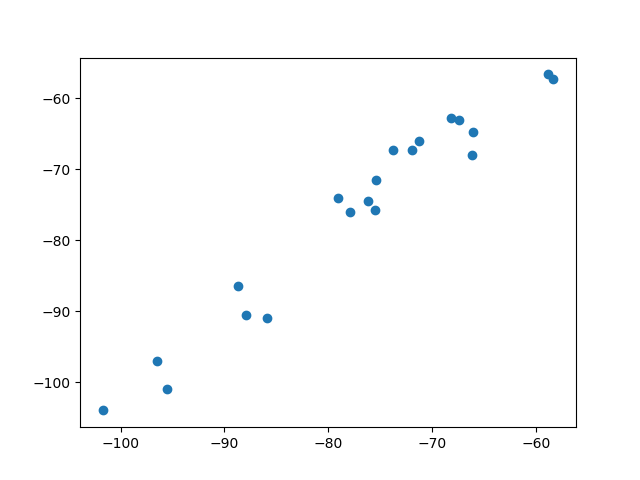

In [43]:
print_score(y_pred, y_test)
plt.plot(y_test, y_pred, 'o')

MAE=8.52e-01 RMSE=1.07e+00 SUP=2.50e+00 R2=9.92e-01 CORR=9.88e-01


<IPython.core.display.Javascript object>


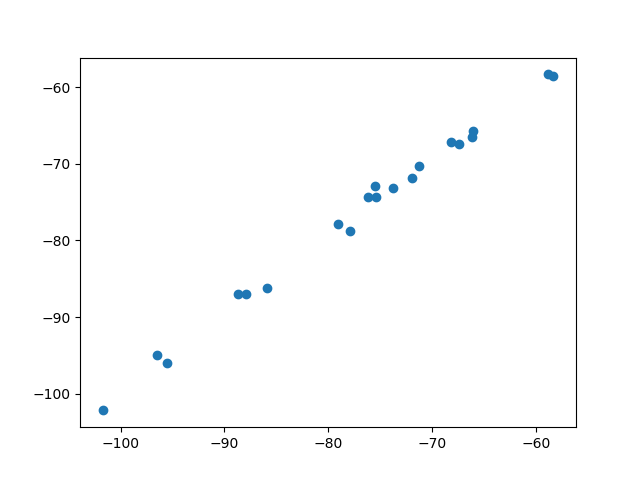

In [39]:
print_score(y_pred, y_test)
plt.plot(y_test, y_pred, 'o')

# testing making a force field

In [6]:
# Total number of structure to load
N = 1000
# Number of structure to train the model with
f = int(0.8*N)

# load the structures
frames = read('../reference_data/inputs/molecule_conformers_dftb.xyz',':{}'.format(N))


global_species = []
for frame in frames:
    global_species.extend(frame.get_atomic_numbers())
global_species = np.unique(global_species)

# split the structures in 2 sets
ids = list(range(N))
np.random.seed(10)
np.random.shuffle(ids)

frames_train = [frames[ii] for ii in ids[:f]]
frames_test = [frames[ii] for ii in ids[f:]]

# Isolated atom contributions
self_contributions = {
    1: -6.492647589968434,
    6: -38.054950840332474,
    8: -83.97955098636527,
}

In [8]:
# ffs = []
# for ff in frames:
    # cell = np.eye(3)*6.
    # pp = ff.positions
    # CoM = pp.mean(axis=0)
    # pp = pp - CoM + np.array([3,3,3])
    # ff.set_cell(cell)
    # ff.set_positions(pp)
    # ffs.append(ff.copy())

In [9]:
# write('../reference_data/inputs/molecule_conformers_dftb.xyz', ffs)

In [7]:
y_train, f_train = extract_ref(frames_train,'dftb_energy_eV','dftb_forces_eV_per_Ang')
y_test, f_test = extract_ref(frames_test,'dftb_energy_eV','dftb_forces_eV_per_Ang')

In [8]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=6, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              normalize=True,
              radial_basis="GTO",
              compute_gradients=False,
              expansion_by_species_method='user defined',
              global_species = [1,6,8],
              )
soap = SOAP(**hypers)

managers = soap.transform(frames)

# Select pseudo input with CUR decomposition
n_pseudo = {1:400,6:300,8:200}

compressor = CURFilter(soap, n_pseudo, act_on='sample per specie')

X_pseudo = compressor.fit_transform(managers)
del managers

The number of pseudo points selected by central atom species is: {1: 400, 6: 300, 8: 200}
Selecting species: 1
Reconstruction RMSE=8.943e-02
Selecting species: 6
Reconstruction RMSE=4.618e-02
Selecting species: 8
Reconstruction RMSE=1.108e-02


In [9]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=6, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              normalize=True,
              radial_basis="GTO",
              compute_gradients=True,
              expansion_by_species_method='user defined',
              global_species = [1,6,8],
              )
soap = SOAP(**hypers)
zeta = 1
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

In [10]:
managers_train = soap.transform(frames_train)
managers_test = soap.transform(frames_test)

In [11]:
KNM = kernel(managers_train, X_pseudo)
# KNM_down = kernel(managers_train, X_pseudo, grad=(True, False))
# KNM = np.vstack([KNM, KNM_down])
# del KNM_down
# KNM_down = []

In [15]:
KNM_down = kernel(managers_train, X_pseudo, grad=(True, False))

In [16]:
KNM_down[:800,:1000]

array([[-7.21131763e-02,  1.60941899e-01, -5.73032231e-02, ...,
        -1.82065057e-01, -1.51855171e-01, -3.35350354e-01],
       [ 7.95610717e-03,  1.37723352e-01, -2.16991293e-03, ...,
        -2.16550857e-02,  6.79896389e-03, -3.08260019e-02],
       [-6.73055237e-03, -1.80296518e-02,  1.65504417e-03, ...,
         6.32310908e-03,  8.70430266e-05, -8.36667846e-03],
       ...,
       [ 4.29918471e-02,  2.46497797e-01, -6.14669613e-02, ...,
        -3.48125989e-02, -4.68176710e-02, -5.50562062e-02],
       [ 5.42673989e-02,  5.08347913e-02, -2.48180179e-02, ...,
         2.79661094e-03,  6.00133971e-03,  6.39706131e-03],
       [ 3.18093013e-02,  6.80615695e-02,  6.91891341e-03, ...,
        -5.37509091e-02, -7.79340938e-02, -9.38593211e-02]])

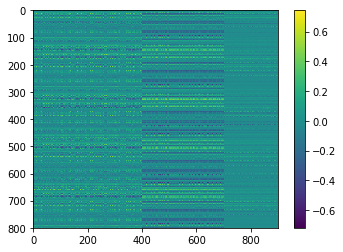

In [17]:
plt.imshow(KNM_down[:800])
plt.colorbar()

In [12]:
# model = train_sparse_kernel(kernel, managers_train, X_pseudo, y_train, self_contributions, 
#                         f_train=f_train, lambdas=[1e-2,1e-1], jitter=6e-9)
# model = train_sparse_kernel_2(kernel, managers_train, KNM, X_pseudo, y_train, self_contributions, 
#                         f_train=f_train, lambdas=[10e-3, 0.05], jitter=1e-7)
model = train_sparse_kernel_2(kernel, managers_train, KNM[:len(managers_train)], X_pseudo, y_train, self_contributions, 
                        f_train=None, lambdas=[7e-3, 1e-2], jitter=2e-7)


(1.8165962059056304e-07+0j)


In [13]:
y_pred = model.predict(managers_test)
f_pred = -model.predict(managers_test, compute_gradients=True)

MAE=3.19e-02 RMSE=6.31e-02 SUP=6.89e-01 R2=9.95e-01 CORR=9.98e-01
MAE=1.06e+00 RMSE=1.52e+00 SUP=6.90e+00 R2=-3.11e-01 CORR=-2.73e-02


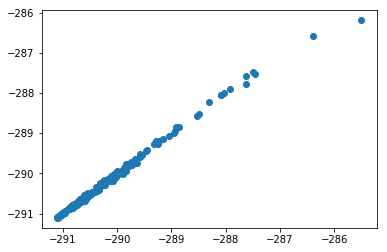

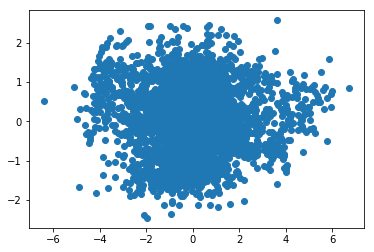

In [14]:
print_score(y_pred, y_test)
print_score(f_pred.flatten(), f_test.flatten())
plt.plot(y_test, y_pred, 'o')
plt.show()
plt.plot(f_test[:,:].flatten(), f_pred[:,:].flatten(), 'o')

In [78]:
del model

In [45]:
#creating atoms pairs, H is 1, C is 6 and O is 8, the first atom is the origin one
pairs = [[1,1],[6,6],[8,8],[6,1],[8,1],[6,8]]
ndists = 40 #number of distances to look at
dists = np.linspace(0.1,4.9,ndists) #distance list, can be changed 
print('Number of configurations: ', len(pairs)*len(dists))

Number of configurations:  240


In [47]:
frames = []
for p in pairs:
    for d in dists:
        #using ase we can create the cell and place the atoms
        atoms = ase.Atoms(numbers=p,pbc=False,cell=np.eye(3)*10,positions=[[0,0,0],[d,0,0]])
        frames.append(atoms)
X = soap.transform(frames)
e_pairs = model.predict(X)
e_pairs -= e_pairs.mean()

<IPython.core.display.Javascript object>


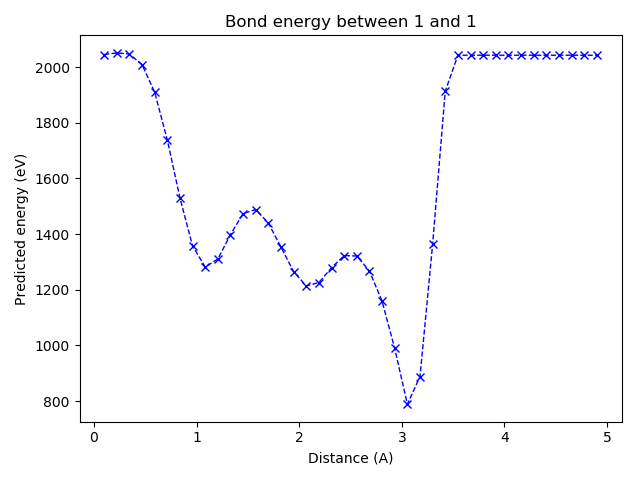

<IPython.core.display.Javascript object>


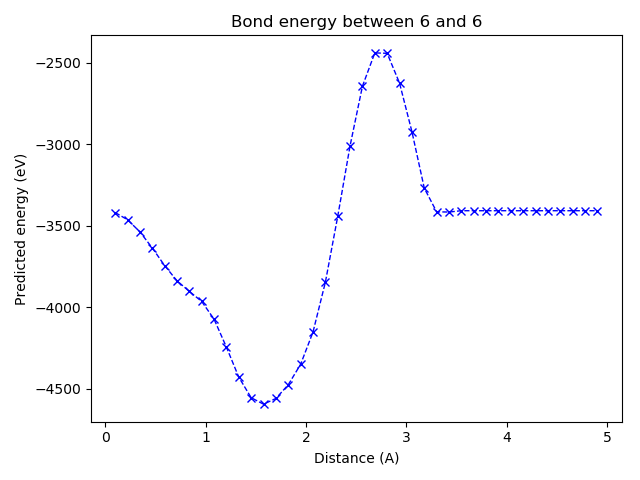

<IPython.core.display.Javascript object>


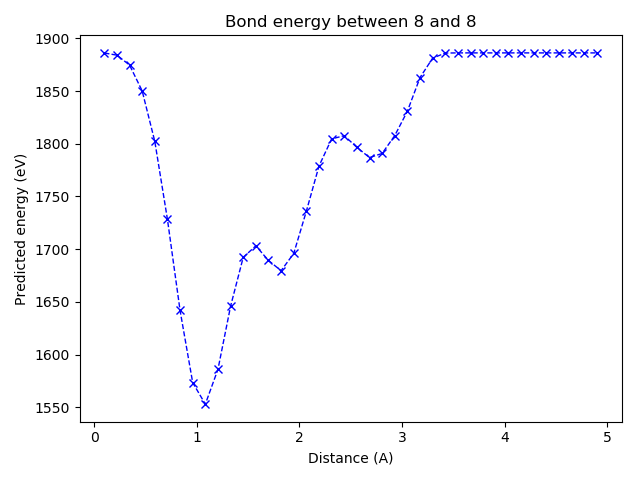

<IPython.core.display.Javascript object>


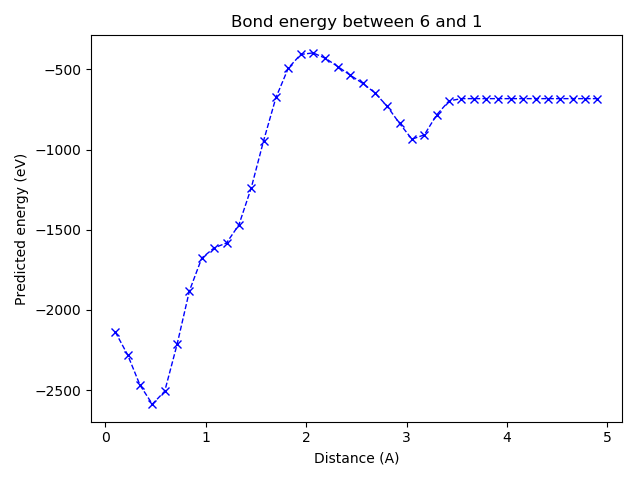

<IPython.core.display.Javascript object>


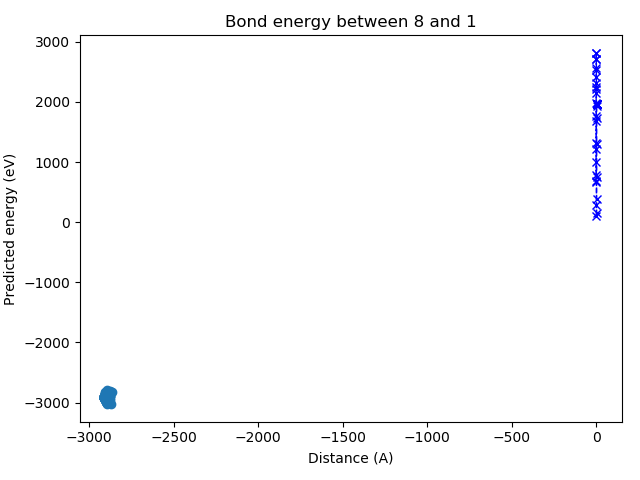

<IPython.core.display.Javascript object>


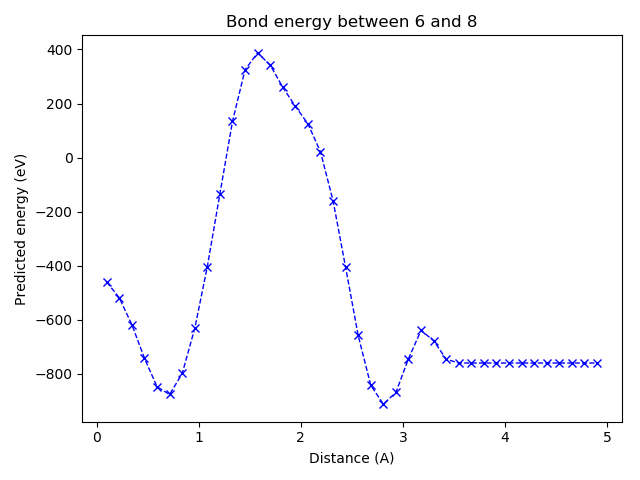

In [48]:
for pair_to_plot in pairs:
    i = pairs.index(pair_to_plot)

    fig, ax = plt.subplots()
    ax.plot(dists,e_pairs[i*ndists:(i+1)*ndists],'--xb',linewidth=1)
    # ax.plot(dists,f_pairs[i*ndists:(i+1)*ndists],'--xr',linewidth=1)
    ax.set_xlabel('Distance (A)')
    ax.set_ylabel('Predicted energy (eV)')
    ax.set_title('Bond energy between {} and {}'.format(*pair_to_plot))
    plt.tight_layout()
    plt.show()

# SOAP: Power spectrum

In [11]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=1, 
              max_angular=1, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              normalize=True,
              )
soap = SOAP(**hypers)
zeta=1
kernel1 = Kernel(soap,name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse')

In [4]:
Xs = []
for frame in frames:
    representation = soap.transform([frame])
    X = representation.get_features(soap, species=[1, 6, 7, 8])
    Xs.append(X)

In [5]:
%%time
for ii,X in enumerate(Xs):
    for jj,Y in enumerate(Xs):
        # if jj < ii: continue
        aa = np.sum(np.power(np.dot(X, Y.T), zeta))

CPU times: user 1min 1s, sys: 0 ns, total: 1min 1s
Wall time: 1min 1s


In [6]:
representation = soap.transform(frames)
X = representation.get_features(soap)

In [7]:
%%time 
kk = np.power(np.dot(X, X.T), zeta)

CPU times: user 25.5 s, sys: 3.18 s, total: 28.7 s
Wall time: 8.2 s


In [21]:
%time kernel1(representation)

CPU times: user 4.19 s, sys: 7.93 ms, total: 4.2 s
Wall time: 4.2 s


array([[1.        , 0.00472567, 0.11009869, ..., 0.04595198, 0.04978086,
        0.03560331],
       [0.00472567, 1.        , 0.11667004, ..., 0.05571336, 0.06607319,
        0.04509975],
       [0.11009869, 0.11667004, 1.        , ..., 0.05723611, 0.06780385,
        0.06020636],
       ...,
       [0.04595198, 0.05571336, 0.05723611, ..., 1.        , 0.85119125,
        0.84384698],
       [0.04978086, 0.06607319, 0.06780385, ..., 0.85119125, 1.        ,
        0.84252262],
       [0.03560331, 0.04509975, 0.06020636, ..., 0.84384698, 0.84252262,
        1.        ]])

In [4]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=4, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              expansion_by_species_method='user defined',
              normalize=True,
              global_species=[1, 6, 7, 8],
              )
soap = SOAP(**hypers)
zeta=2
kernel1 = Kernel(soap, zeta=zeta, target_type='Atom')
representation = soap.transform(frames)

In [8]:
%time kernel1(representation)

CPU times: user 28.1 s, sys: 500 ms, total: 28.6 s
Wall time: 28.7 s


array([[1.        , 0.00472567, 0.11009869, ..., 0.04753737, 0.02975926,
        0.00890048],
       [0.00472567, 1.        , 0.11667004, ..., 0.06367934, 0.02375891,
        0.00288407],
       [0.11009869, 0.11667004, 1.        , ..., 0.0790658 , 0.03902808,
        0.00189056],
       ...,
       [0.04753737, 0.06367934, 0.0790658 , ..., 1.        , 0.72615537,
        0.33178025],
       [0.02975926, 0.02375891, 0.03902808, ..., 0.72615537, 1.        ,
        0.46487243],
       [0.00890048, 0.00288407, 0.00189056, ..., 0.33178025, 0.46487243,
        1.        ]])

In [5]:
aa = kernel1(representation)
bb = kernel1(representation, representation)
np.allclose(aa, bb)

True

3.508771929824561

# Learning the formation energies of small molecules

In [ ]:
# Load the small molecules 
frames = read('../reference_data/inputs/small_molecules-1000.xyz',':600')

## learning utilities

In [ ]:
def compute_representation(representation,frames):
    expansions = soap.transform(frames)
    return expansions

def compute_kernel(zeta, rep1, rep2=None):
    if rep2 is None:
        kernel = rep1.cosine_kernel_global(zeta)
    else:
        kernel = rep1.cosine_kernel_global(rep2,zeta)
    return kernel

def extract_energy(frames):
    prop = [[]]*len(frames)
    for ii,cc in enumerate(frames):
        prop[ii] = cc.info['dft_formation_energy_per_atom_in_eV']
    y = np.array(prop)
    return y

def split_dataset(frames, test_fraction, seed=10):
    N = len(frames)
    ids = np.arange(N)
    np.random.seed(seed)
    np.random.shuffle(ids)
    Ntrain = int(N*test_fraction)
    train = ids[:Ntrain]
    test = ids[Ntrain:]
    targets = extract_energy(frames)
    return [frames[ii] for ii in train],targets[train],[frames[ii] for ii in test],targets[test]

def get_mae(ypred,y):
    return np.mean(np.abs(ypred-y))
def get_rmse(ypred,y):
    return np.sqrt(np.mean((ypred-y)**2))
def get_sup(ypred,y):
    return np.amax(np.abs((ypred-y)))
def get_r2(y_pred,y_true):
    weight = 1
    sample_weight = None
    numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,dtype=np.float64)
    denominator = (weight * (y_true - np.average(
        y_true, axis=0, weights=sample_weight)) ** 2).sum(axis=0,dtype=np.float64)
    output_scores = 1 - (numerator / denominator)
    return np.mean(output_scores)


score_func = dict(
    MAE=get_mae,
    RMSE=get_rmse,
    SUP=get_sup,
    R2=get_r2,
)

def get_score(ypred,y):
    scores = {}
    for k,func in score_func.items():
        scores[k] = func(ypred,y)
    return scores

class KRR(object):
    def __init__(self,zeta,weights,representation,X):
        self.weights = weights
        self.representation = representation
        self.zeta = zeta
        self.X = X
        
    def predict(self,frames):
        features = compute_representation(self.representation,frames)
        kernel = compute_kernel(self.zeta , self.X, features)
        return np.dot(self.weights, kernel)
    
def train_krr_model(zeta,Lambda,representation,frames,y,jitter=1e-8):
    features = compute_representation(representation,frames)
    kernel = compute_kernel(zeta,features)    
    # adjust the kernel so that it is properly scaled
    delta = np.std(y) / np.mean(kernel.diagonal())
    kernel[np.diag_indices_from(kernel)] += Lambda**2 / delta **2 + jitter
    # train the krr model
    weights = np.linalg.solve(kernel,y)
    model = KRR(zeta, weights,representation, features)
    return model,kernel



## With the full power spectrum

In [ ]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=6, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )
soap = SOAP(**hypers)

In [ ]:
frames_train, y_train, frames_test, y_test = split_dataset(frames,0.8)

In [ ]:
zeta = 2
Lambda = 5e-3
krr,k = train_krr_model(zeta, Lambda, soap, frames_train, y_train)

In [ ]:
y_pred = krr.predict(frames_test)
get_score(y_pred, y_test)

In [ ]:
plt.scatter(y_pred, y_test, s=3)
plt.axis('scaled')
plt.xlabel('DFT energy / (eV/atom)')
plt.ylabel('Predicted energy / (eV/atom)')

## With just the radial spectrum

In [ ]:
hypers = dict(soap_type="RadialSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=0, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )
soap = SOAP(**hypers)

In [ ]:
frames_train, y_train, frames_test, y_test = split_dataset(frames,0.8)

In [ ]:
zeta = 2
Lambda = 5e-4
krr,k = train_krr_model(zeta, Lambda, soap, frames_train, y_train)

In [ ]:
y_pred = krr.predict(frames_test)
get_score(y_pred, y_test)

In [ ]:
plt.scatter(y_pred, y_test, s=3)
plt.axis('scaled')
plt.xlabel('DFT energy / (eV/atom)')
plt.ylabel('Predicted energy / (eV/atom)')

# Make a map of the dataset

## utils

In [ ]:
def compute_representation(representation,frames):
    expansions = soap.transform(frames)
    return expansions

def compute_kernel(zeta, rep1, rep2=None):
    if rep2 is None:
        kernel = rep1.cosine_kernel_global(zeta)
    else:
        kernel = rep1.cosine_kernel_global(rep2,zeta)
    return kernel

In [ ]:
def link_ngl_wdgt_to_ax_pos(ax, pos, ngl_widget):
    from matplotlib.widgets import AxesWidget
    from scipy.spatial import cKDTree
    r"""
    Initial idea for this function comes from @arose, the rest is @gph82 and @clonker
    """
    
    kdtree = cKDTree(pos)        
    #assert ngl_widget.trajectory_0.n_frames == pos.shape[0]
    x, y = pos.T
    
    lineh = ax.axhline(ax.get_ybound()[0], c="black", ls='--')
    linev = ax.axvline(ax.get_xbound()[0], c="black", ls='--')
    dot, = ax.plot(pos[0,0],pos[0,1], 'o', c='red', ms=7)

    ngl_widget.isClick = False
    
    def onclick(event):
        linev.set_xdata((event.xdata, event.xdata))
        lineh.set_ydata((event.ydata, event.ydata))
        data = [event.xdata, event.ydata]
        _, index = kdtree.query(x=data, k=1)
        dot.set_xdata((x[index]))
        dot.set_ydata((y[index]))
        ngl_widget.isClick = True
        ngl_widget.frame = index
    
    def my_observer(change):
        r"""Here comes the code that you want to execute
        """
        ngl_widget.isClick = False
        _idx = change["new"]
        try:
            dot.set_xdata((x[_idx]))
            dot.set_ydata((y[_idx]))            
        except IndexError as e:
            dot.set_xdata((x[0]))
            dot.set_ydata((y[0]))
            print("caught index error with index %s (new=%s, old=%s)" % (_idx, change["new"], change["old"]))
    
    # Connect axes to widget
    axes_widget = AxesWidget(ax)
    axes_widget.connect_event('button_release_event', onclick)
    
    # Connect widget to axes
    ngl_widget.observe(my_observer, "frame", "change")

## make a map with kernel pca projection

In [ ]:
# Load the small molecules 
frames = read('./reference_data/small_molecules-1000.xyz',':600')

In [ ]:
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=3.5, 
              max_radial=6, 
              max_angular=6, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              )
soap = SOAP(**hypers)

In [ ]:
zeta = 2

features = compute_representation(soap, frames)

kernel = compute_kernel(zeta,features)

In [ ]:
from sklearn.decomposition import KernelPCA

In [ ]:
kpca = KernelPCA(n_components=2,kernel='precomputed')
kpca.fit(kernel)

In [ ]:
X = kpca.transform(kernel)

In [ ]:
plt.scatter(X[:,0],X[:,1],s=3)

## make an interactive map

In [ ]:
# package to visualize the structures in the notebook
# https://github.com/arose/nglview#released-version
import nglview

In [ ]:
iwdg = nglview.show_asetraj(frames)
# set up the visualization
iwdg.add_unitcell()
iwdg.add_spacefill()
iwdg.remove_ball_and_stick()
iwdg.camera = 'orthographic'
iwdg.parameters = { "clipDist": 0 }
iwdg.center()
iwdg.update_spacefill(radiusType='covalent',
                                   scale=0.6,
                                   color_scheme='element')
iwdg._remote_call('setSize', target='Widget',
                               args=['%dpx' % (600,), '%dpx' % (400,)])
iwdg.player.delay = 200.0

In [ ]:
link_ngl_wdgt_to_ax_pos(plt.gca(), X, iwdg)
plt.scatter(X[:,0],X[:,1],s=3)
iwdg